# Kaggle Leaf Classification Challenge


In [2]:
## Install pandas if you don't already have it (uncomment line below)

# ! pip install pandas

# Load functions
import torch
#print the version of torch
print(torch.__version__)
# Specifically for Intel ARC GPU's to be able to run on the XPUs
#import intel_extension_for_pytorch as ipex
use_ipex = True

2.4.1+cu121


In [3]:
## If you are working on Colab, data_utils can be downloaded using the command below (uncomment line below)
# ! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch/6_Mini_Project/leaf-classification
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you are running this notebook on Google Colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from Kaggle to Colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. Upload the data to Google Drive
2. Mount the Google Drive (see cell below)

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [6]:
#!ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [7]:
#path = 'drive/My Drive/leaf-classification/'
path = 'leaf-classification/'  # if you're folder structure is as defined above and you want to run locally

# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [8]:
image_paths = glob.glob(path+'images/*.jpg')
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv(path + 'train.csv')
train_images = [path+'images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv(path + 'test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [9]:
# Your code here:
#  Check how many samples we have for training and testing
print("Training Observations:\t", len(train_images))
print("Testing Observations:\t", len(test))

# Check if we have the same columns in training vs test
print(train.columns.symmetric_difference(test.columns))


# See how many examples each species has
species_list_train = pd.unique(train.species)

# Need to be same for both train and test
# Now for each species, we count how many training examples we have
train_species_count = {}
for species in species_list_train:
    train_species_count[species] = len(train[train.species == species])

print("Species\t\tTrain")
for species in species_list_train:
    print("{:15s}\t{}".format(species, train_species_count[species]))

# Check if all the species in the training set have the same number of examples
for species in species_list_train:
    if train_species_count[species] != train_species_count[species_list_train[0]]:
        print("Different number of training examples for species")
        break
print("All species have the same number of training examples")


Training Observations:	 990
Testing Observations:	 594
Index(['species'], dtype='object')
Species		Train
Acer_Opalus    	10
Pterocarya_Stenoptera	10
Quercus_Hartwissiana	10
Tilia_Tomentosa	10
Quercus_Variabilis	10
Magnolia_Salicifolia	10
Quercus_Canariensis	10
Quercus_Rubra  	10
Quercus_Brantii	10
Salix_Fragilis 	10
Zelkova_Serrata	10
Betula_Austrosinensis	10
Quercus_Pontica	10
Quercus_Afares 	10
Quercus_Coccifera	10
Fagus_Sylvatica	10
Phildelphus    	10
Acer_Palmatum  	10
Quercus_Pubescens	10
Populus_Adenopoda	10
Quercus_Trojana	10
Alnus_Sieboldiana	10
Quercus_Ilex   	10
Arundinaria_Simonii	10
Acer_Platanoids	10
Quercus_Phillyraeoides	10
Cornus_Chinensis	10
Liriodendron_Tulipifera	10
Cytisus_Battandieri	10
Rhododendron_x_Russellianum	10
Alnus_Rubra    	10
Eucalyptus_Glaucescens	10
Cercis_Siliquastrum	10
Cotinus_Coggygria	10
Celtis_Koraiensis	10
Quercus_Crassifolia	10
Quercus_Kewensis	10
Cornus_Controversa	10
Quercus_Pyrenaica	10
Callicarpa_Bodinieri	10
Quercus_Alnifolia	10
Acer_Saccha

 * **Answer:**

 We have 990 samples for training and 594 samples for testing. We have 99 species overall, and each species has 10 samples in the training data. The test data does not contain the species information. All species have the same number of training examples

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

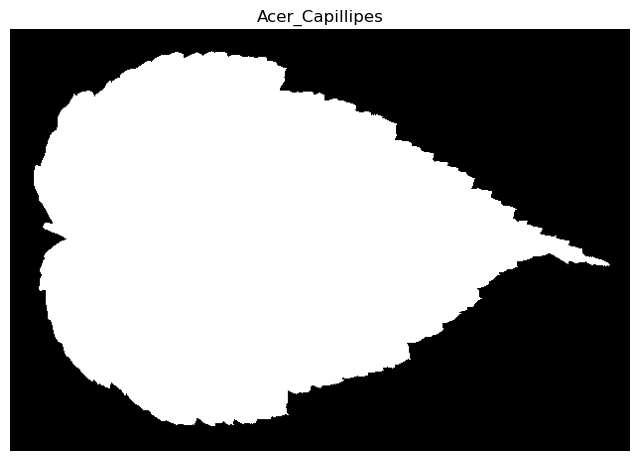

In [10]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index(path + 'images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

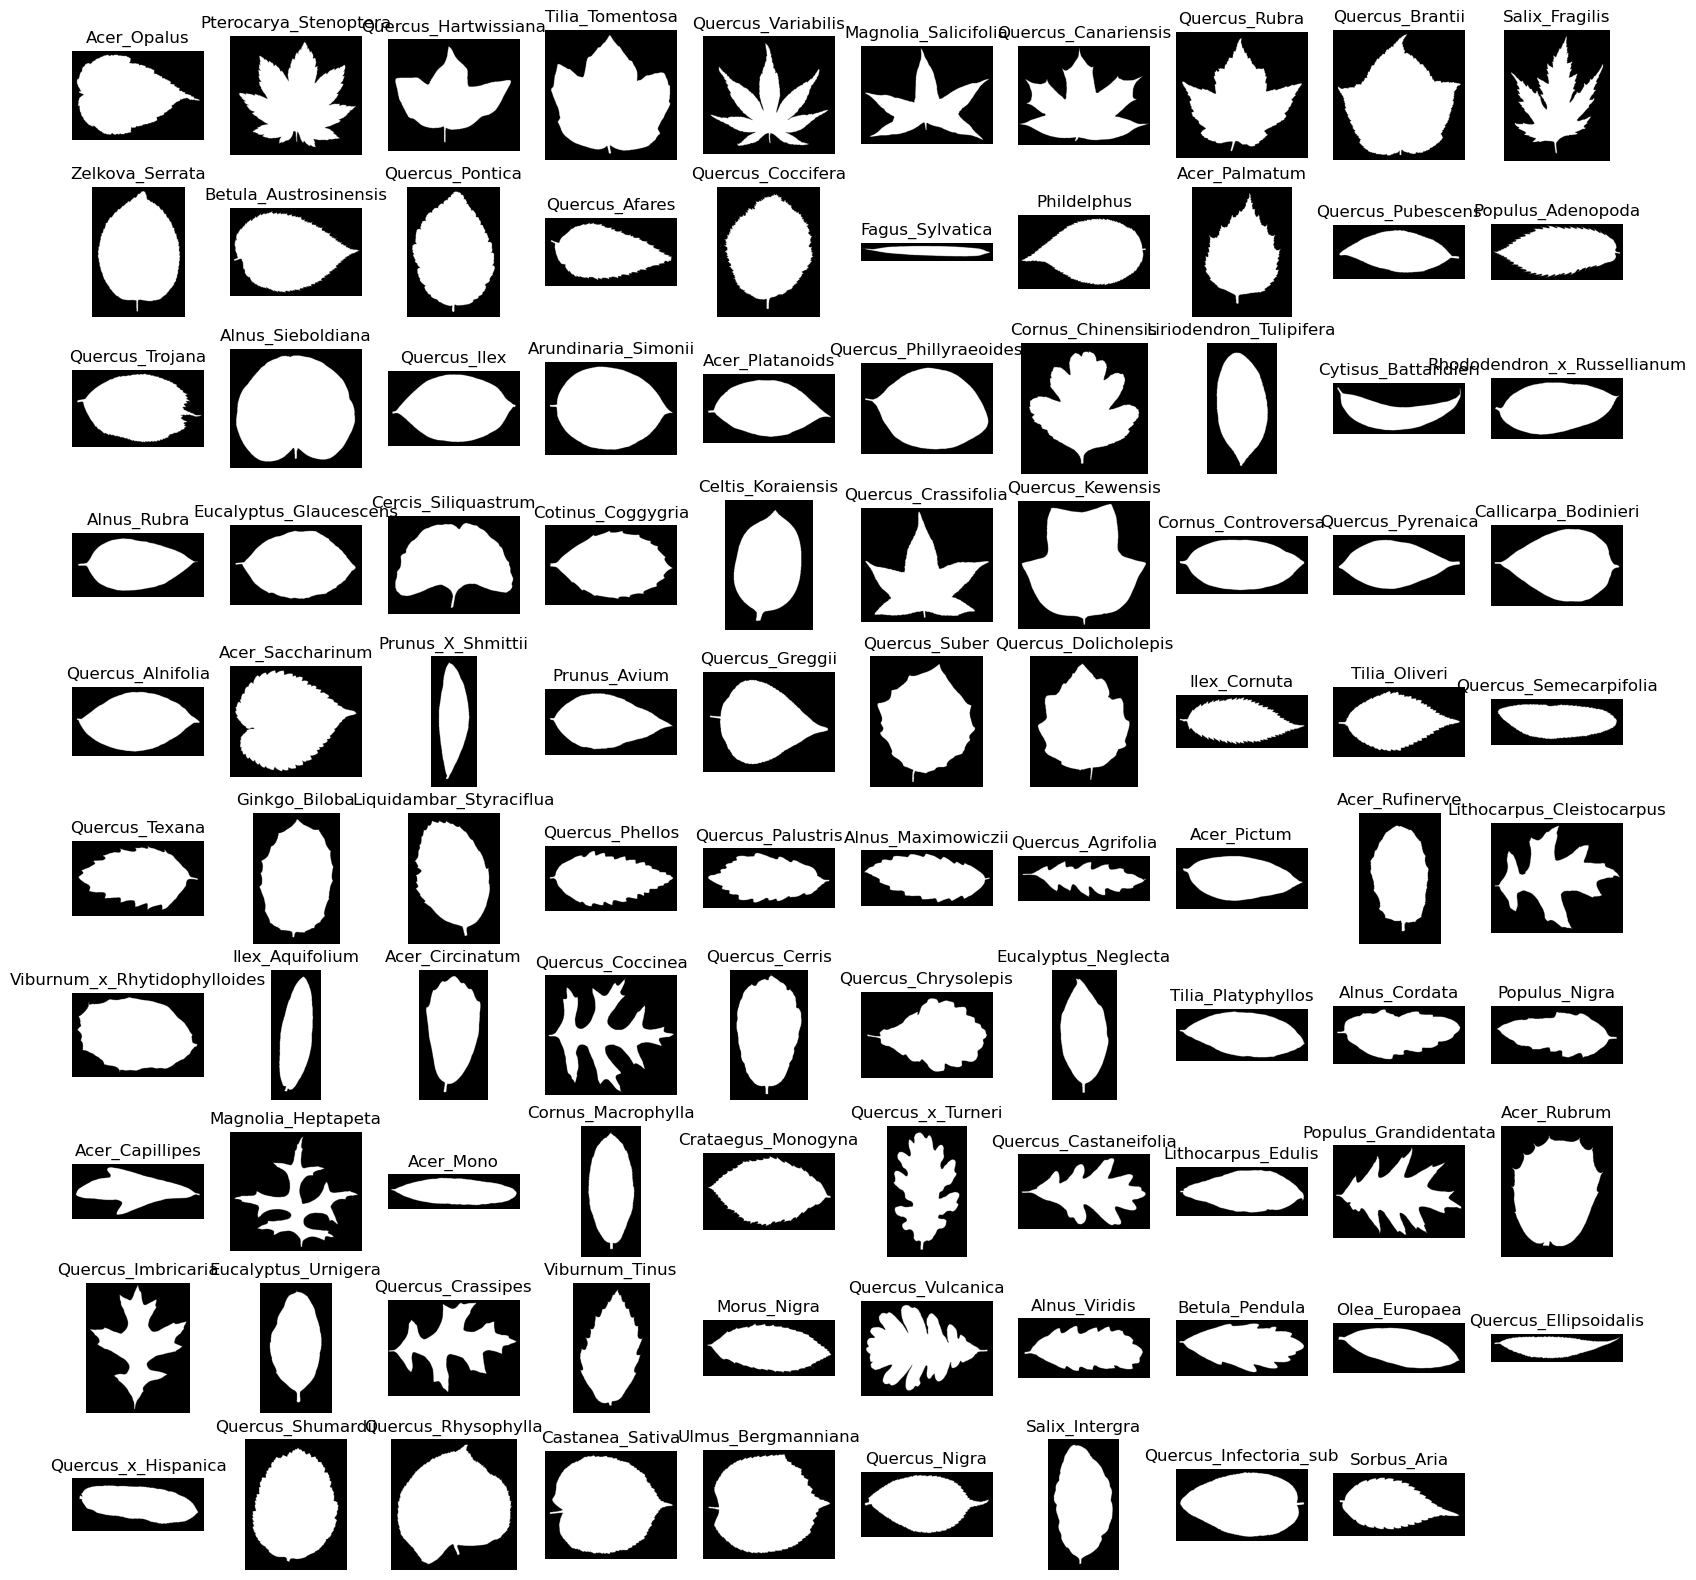

In [11]:
# Now plot 1 image from each category

width_img = 10 
plt.figure(figsize=(20, 20))
for species in enumerate(species_list_train):
    plt.subplot(width_img, width_img, species[0] + 1)
    image = imread(image_paths[indexes[species[0]]], as_gray=True)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (species[1]))
    plt.axis('off')


As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**

I decided on going with a size of 64x64. This is a good compromise between image quality and computational cost.


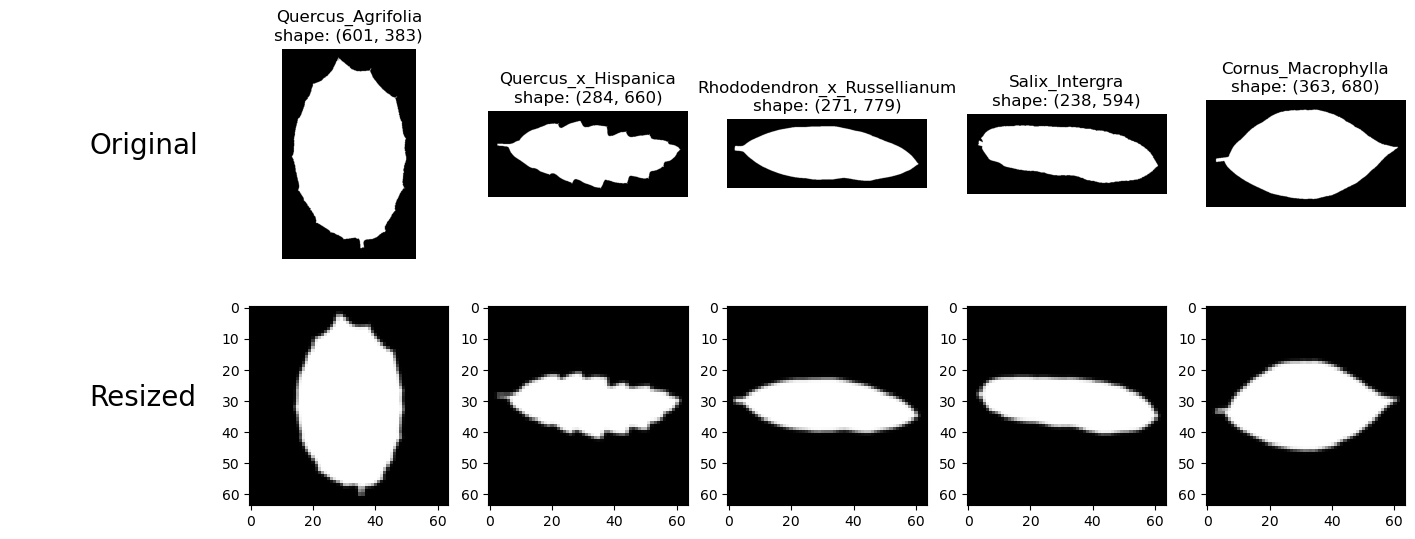

In [12]:
## Image pre-processing
image_size = (64, 64)

# Amount of images
amount = 5
image_sample = np.random.choice(train_images, amount)

# Define figure size
fig = plt.figure(figsize=(18, 6))

# Save original images in the figure
ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_gray=True)    
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')
    
# Save resized images in the figure
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_gray=True)
    image = data_utils.pad2square(image)  # Make the image square
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)  # resizes the image
    plt.imshow(image, cmap='gray')

# Show plot
plt.show()

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

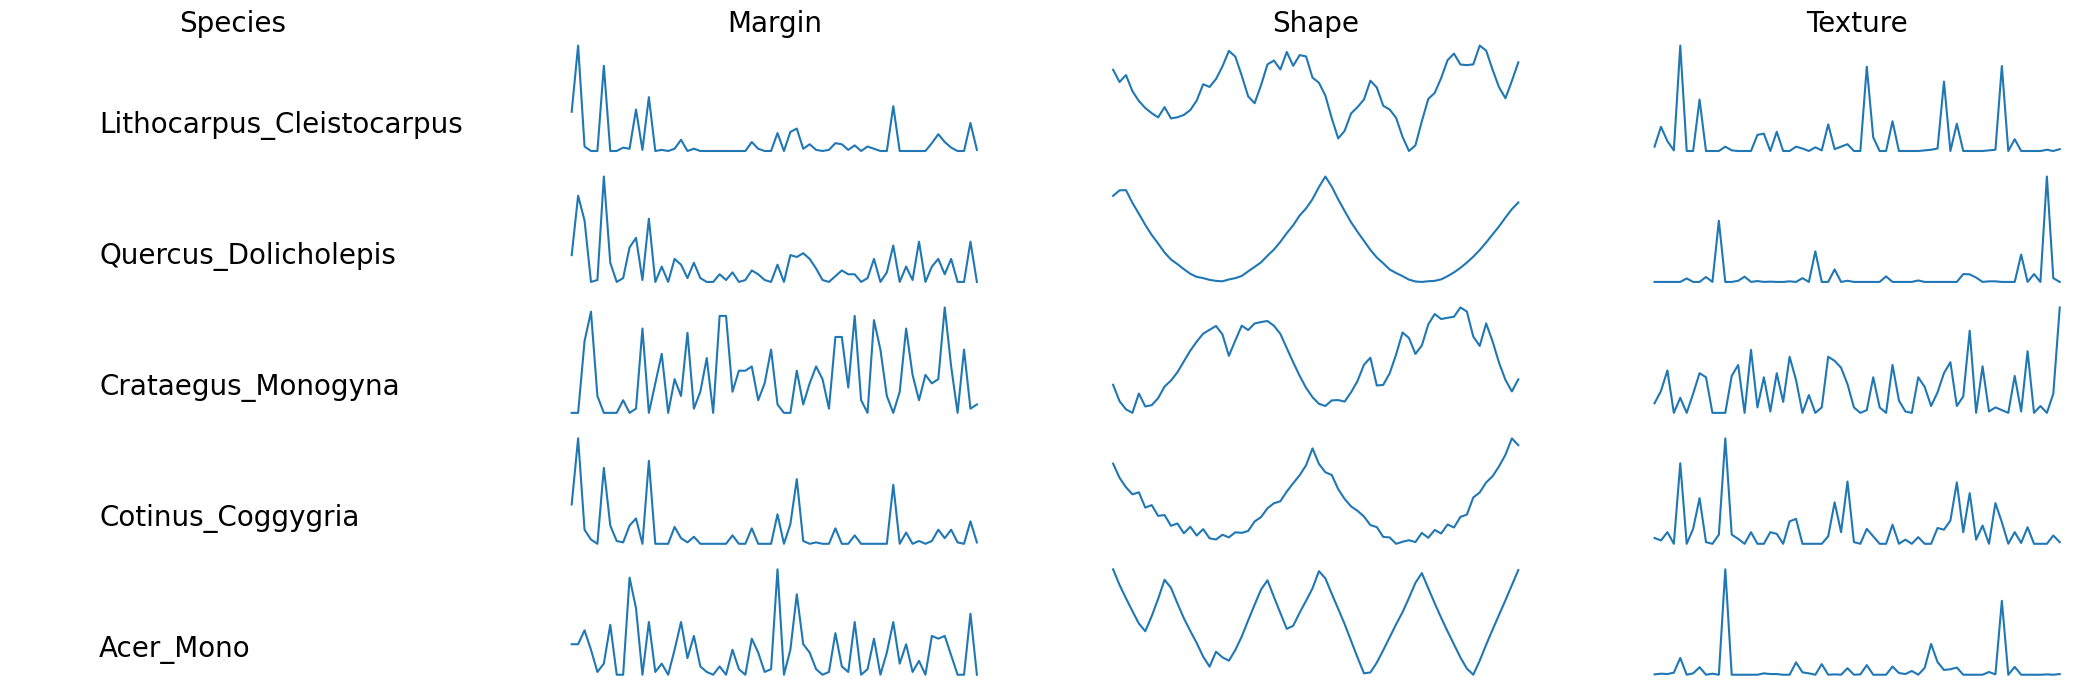

species: [['Acer_Opalus']
 ['Pterocarya_Stenoptera']
 ['Quercus_Hartwissiana']
 ['Tilia_Tomentosa']
 ['Quercus_Variabilis']
 ['Magnolia_Salicifolia']
 ['Quercus_Canariensis']
 ['Quercus_Rubra']
 ['Quercus_Brantii']
 ['Salix_Fragilis']
 ['Zelkova_Serrata']
 ['Betula_Austrosinensis']
 ['Quercus_Pontica']
 ['Quercus_Afares']
 ['Quercus_Coccifera']
 ['Fagus_Sylvatica']
 ['Phildelphus']
 ['Acer_Palmatum']
 ['Quercus_Pubescens']
 ['Populus_Adenopoda']
 ['Quercus_Trojana']
 ['Quercus_Variabilis']
 ['Alnus_Sieboldiana']
 ['Quercus_Ilex']
 ['Arundinaria_Simonii']
 ['Acer_Platanoids']
 ['Quercus_Phillyraeoides']
 ['Cornus_Chinensis']
 ['Quercus_Phillyraeoides']
 ['Fagus_Sylvatica']
 ['Liriodendron_Tulipifera']
 ['Cytisus_Battandieri']
 ['Tilia_Tomentosa']
 ['Rhododendron_x_Russellianum']
 ['Alnus_Rubra']
 ['Eucalyptus_Glaucescens']
 ['Cercis_Siliquastrum']
 ['Cotinus_Coggygria']
 ['Celtis_Koraiensis']
 ['Quercus_Crassifolia']
 ['Quercus_Variabilis']
 ['Quercus_Hartwissiana']
 ['Quercus_Kewensis'

In [13]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5                 # Choose the amount of images we want to show at a time

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("species: {}\nmargin: {}\nshape: {}\ntexture: {}".format(species, margin, shape, texture))


## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 * **Answer:**

A CNN would probable work well for each of them, especially with the image data. A FFNN could also work well with margin, shape, and texture data, as they are all numerical data. A transformer could also work well with texture data, as it is good at capturing complex relationships and long-range dependencies between features.




# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [14]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (image_size[0], image_size[1], 1)
NUM_CLASSES = len(species_list_train)

# For all three features types margin, shape, and texture, we have NUM_FEATURES for each type.
NUM_FEATURES = len(margin[0])

In [15]:
path = 'leaf-classification/'  
# Paths to data
TRAIN_PATH = path + "train.csv" 
TEST_PATH = path + "test.csv" 
IMAGE_PATHS = glob.glob(path + "images/*.jpg")

# train holds both X (input) and t (target/truth)
#data = data_utils.load_data(train_path=TRAIN_PATH, 
#                            test_path=TEST_PATH,
#                            image_paths=IMAGE_PATHS,
#                            image_shape=IMAGE_SHAPE[:2])

import pickle


## Dump the data into a pickle file
#with open(path + '/data.pickle', 'wb') as f:
#    pickle.dump(data, f)

# Load the data from a pickle file
with open(path + '/data.pickle', 'rb') as f:
     data = pickle.load(f)
# to visualize the size of the dimensions of the data
print("\n@@@Shape checking of data sets@@@")
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))


@@@Shape checking of data sets@@@
TRAIN
	images	(990, 64, 64, 1)0.281170
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 64, 64, 1)	0.281457
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time.

In [16]:
import pickle

# # Dump the data into a pickle file
with open(path + '/data.pickle', 'wb') as f:
     pickle.dump(data, f)

In [17]:
# # Load the data from a pickle file
with open(path + '/data.pickle', 'rb') as f:
     data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

Batch size is related to memory, training speed, and gradient estimation. Smaller batch sizes require less memory and are useful on machines with limited resources. However, doing so can make the gradient estimates noisier, leading to less stable training. Larger batch sizes will give more accurate estimates of the gradient, making training much smoother, but they also usually require more memory and can slow down training because they take longer to compute. A reasonable batch size normally balances those factors. Most models will work fine with something in between 32 and 128. I will choose batch_size = 32 since my memory is limited.

In [18]:
#batch_size = 16
if use_ipex:
    batch_size = 16
else:
    batch_size = 32
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (16, 64, 64, 1)
	margins, (16, 64)
	shapes, (16, 64)
	textures, (16, 64)
	ts, (16, 99)

VALID
	images, (16, 64, 64, 1)
	margins, (16, 64)
	shapes, (16, 64)
	textures, (16, 64)
	ts, (16, 99)

TEST
	images, (16, 64, 64, 1)
	margins, (16, 64)
	shapes, (16, 64)
	textures, (16, 64)
	ids, 16


# Build the model

In [19]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

In [20]:
def get_device(use_ipex=False):
    """Get the available device (CUDA, XPU, or CPU)."""
    if use_ipex and torch.xpu.is_available():
        torch.xpu.set_device(0)
        device = torch.device('xpu')
        print("Using Intel® Extension for PyTorch (XPU).")
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print("Using CUDA.")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device


def get_variable_and_numpy_functions(device, use_ipex=False):
    def get_variable(x):
        """ Converts tensors to XPU, if available. """
        if use_ipex:
            return x.to('xpu')
        else:
            return x.to(device)

    def get_numpy(x):
        """ Get numpy array for both XPU and not. """
        if use_ipex or device == 'cuda':
            return x.cpu().data.numpy()
        return x.data.numpy()

    return get_variable, get_numpy

use_cuda = torch.cuda.is_available()
if use_cuda:
    use_ipex = False

device = get_device(use_ipex)
# Get variable and numpy functions
get_variable, get_numpy = get_variable_and_numpy_functions(device, use_ipex)


Using CUDA.


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [27]:
height, width, channels = IMAGE_SHAPE

NUM_FEATURES = len(margin[0])
NUM_CLASSES = len(species_list_train)  # Number of classes


class SelfAttention(nn.Module):
    """Self-Attention Layer for processing feature maps."""

    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv1d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv1d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv1d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        """
        inputs :
            x : input feature maps (B, C, N)
        returns :
            out : self attention value + input feature 
            attention: (B, N, N)
        """
        proj_query = self.query(x).permute(0, 2, 1)  # (B, N, C//8)
        proj_key = self.key(x)  # (B, C//8, N)
        energy = torch.bmm(proj_query, proj_key)  # (B, N, N)
        attention = self.softmax(energy)  # (B, N, N)
        proj_value = self.value(x)  # (B, C, N)
        
        out = torch.bmm(attention, proj_value.permute(0, 2, 1))  # (B, N, C)
        out = out.permute(0, 2, 1)  # (B, C, N)
        out = self.gamma * out + x
        return out

class CNNBlock(nn.Module):
    """CNNBlock Block with two convolutional layers and a shortcut connection."""

    def __init__(self, in_channels, out_channels, stride=1, dropout_p=0.2):
        super(CNNBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.actf = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_p)

        # Shortcut connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.actf(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Add shortcut connection
        out = self.actf(out)

        return out


class CNNBranch(nn.Module):
    """CNN Branch for processing image data with Self Attention."""

    def __init__(self, input_channels, dropout_p=0.2):
        super(CNNBranch, self).__init__()
        self.layer1 = self._make_layer(input_channels, 64, stride=1)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)
        self.layer5 = self._make_layer(512, 512, stride=2)
        self.layer6 = self._make_layer(512, 512, stride=2)

        # Self-Attention Layer
        self.attention = SelfAttention(in_dim=512)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_p)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            CNNBlock(in_channels, out_channels, stride=stride, dropout_p=0.2)
        )

    def forward(self, x):
        """
        Forward pass for CNN branch with Multi-Headed Attention.

        Args:
            x (Tensor): Input image tensor (B, C, H, W).

        Returns:
            Tensor: Extracted image features (B, 512).
        """
        x = self.layer1(x)  # [B, 128, H, W]
        x = self.layer2(x)  # [B, 256, H/2, W/2]
        x = self.layer3(x)  # [B, 256, H/4, W/4]
        x = self.layer4(x)  # [B, 512, H/8, W/8]
        x = self.layer5(x)
        x = self.layer6(x)

        # Reshape for self-attention
        B, C, H, W = x.size()
        x = x.view(B, C, -1)
        
        # Apply self-attention
        x = self.attention(x)
        x = x.view(B, C, H, W)
        
        x = self.global_avg_pool(x)
        x = x.view(B, -1)  # Flatten the tensor
        x = self.dropout(x)

        return x


class NumericalBranch(nn.Module):
    """Numerical Branch for processing numerical features with self-attention."""

    def __init__(self, input_size, hidden_sizes=[128, 64], dropout_p=0.2):
        super(NumericalBranch, self).__init__()
        layers = []
        current_size = input_size
        for hidden_size in hidden_sizes:
            layers.extend(
                [
                    nn.BatchNorm1d(current_size),
                    nn.Linear(current_size, hidden_size),
                    nn.LeakyReLU(inplace=True),
                    nn.Dropout(dropout_p),
                ]
            )
            current_size = hidden_size
        self.fc = nn.Sequential(*layers)

        self.attention = SelfAttention(current_size)
        self.residual = nn.Sequential(
           nn.BatchNorm1d(input_size),
           nn.Linear(input_size, current_size),
        )

    def forward(self, x):
        """
        Forward pass for numerical branch.

        Args:
            x (Tensor): Input numerical features (B, input_size).

        Returns:
            Tensor: Processed numerical features (B, hidden_sizes[-1]).
        """
        residual = self.residual(x)
        out = self.fc(x)  # Shape: (B, C)
        # Add a sequence length dimension
        out = out.unsqueeze(-1)  # Shape: (B, C, 1)
        # Apply self-attention
        out = self.attention(out)  # Shape: (B, C, 1)
        # Remove the sequence length dimension
        out = out.squeeze(-1)  # Shape: (B, C)
        # Add residual connection
        out += residual
        return out


class Classifier(nn.Module):
    """Classifier combining CNN and Numerical branches."""

    def __init__(self, input_dim, num_classes, dropout_p=0.3):
        super(Classifier, self).__init__()
        # combined_features = cnn_output_dim + numerical_output_dim
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        """
        Forward pass for classifier.

        Args:
            x (Tensor): Combined features from CNN and Numerical branches.

        Returns:
            Tensor: Class logits (B, num_classes).
        """
        return self.classifier(x)


class Net(nn.Module):
    """Combined Model for Image and Numerical Data with Attention."""

    def __init__(
        self, num_image_channels, num_numerical_features, num_classes
    ):
        super(Net, self).__init__()
        cnn_output_dim = 512
        self.cnn = CNNBranch(input_channels=num_image_channels, dropout_p=0.4)
        numerical_output_dim = 128
        self.numerical = NumericalBranch(
            input_size=num_numerical_features * 3, hidden_sizes=[512, 256, numerical_output_dim], dropout_p=0.4
        )

        # Test fusion layer
        self.fusion = nn.Sequential(
            nn.BatchNorm1d(cnn_output_dim + numerical_output_dim),
            nn.Linear(cnn_output_dim + numerical_output_dim, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.2),
        )

        self.classifier = Classifier(input_dim=512, num_classes=num_classes, dropout_p=0.4)

    def forward(self, x_img, x_margin, x_shape, x_texture):
        """
        Forward pass for the combined model.

        Args:
            x_img (Tensor): Image data (B, H, W, C).
            x_margin (Tensor): Margin features (B, F).
            x_shape (Tensor): Shape features (B, F).
            x_texture (Tensor): Texture features (B, F).

        Returns:
            dict: Output logits.
        """
        # Process image data
        x_img = x_img.permute(0, 3, 1, 2)  # (B, C, H, W)
        img_features = self.cnn(x_img)

        # Concatenate numerical features
        numerical_features = torch.cat((x_margin, x_shape, x_texture), dim=1)
        numerical_features = self.numerical(numerical_features)

        # Combine features
        combined = torch.cat((img_features, numerical_features), dim=1)

        # Fusion layer
        combined = self.fusion(combined)

        # Classifier
        logits = self.classifier(combined)
        return {"out": logits}


def initialize_weights(model):
    """Initialize model weights using appropriate strategies."""
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="leaky_relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)


# Initialize model
model = Net(
    num_image_channels=channels,
    num_numerical_features=NUM_FEATURES,
    num_classes=NUM_CLASSES,
)

# Initialize weights
initialize_weights(model)

# Move model to appropriate device
device = get_device(use_ipex=use_ipex)
model.to(device)
model.train()

print(model)

Using CUDA.
Net(
  (cnn): CNNBranch(
    (layer1): Sequential(
      (0): CNNBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (actf): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (shortcut): Sequential(
          (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layer2): Sequential(
      (0): CNNBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [28]:
from torch.optim import AdamW

LEARNING_RATE = 0.001
# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Loss Function
criterion = nn.CrossEntropyLoss()

# weight_decay is equal to L2 regularization
#optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# Add weight decay
#optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
#optimizer = optim.Adadelta(net.parameters(), rho=0.9, eps=1e-06, weight_decay=0.0001)  

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

# Initialize the scheduler
# Using ReduceLROnPlateau to reduce LR when a metric has stopped improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=10, 
    verbose=True
)


/home/joeli/.conda/envs/dl/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [29]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = model(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 1.9389,  1.8851,  0.1160,  ..., -1.4526, -1.2832, -0.9768],
        [-1.8166, -1.9648, -0.4462,  ..., -0.5998, -1.7870, -0.7395],
        [-0.7309, -2.0005, -0.8824,  ..., -1.8742,  1.0699,  2.2068],
        ...,
        [ 0.8305,  2.3823,  0.0069,  ...,  0.5535, -0.3273,  1.6073],
        [-1.8940,  0.4373, -0.3392,  ..., -0.9392,  0.0227,  0.3353],
        [-1.0964,  1.3249,  2.0350,  ...,  0.8732,  0.0148,  1.8637]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Train

Current Learning Rate: 1.0000000000000004e-08


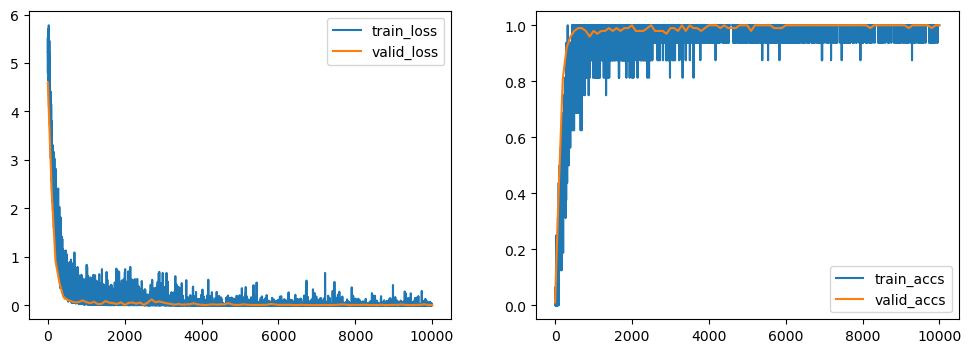

In [30]:

criterion = nn.CrossEntropyLoss().to(device)
#net, optimizer = torch.xpu.optimize(net, optimizer=optimizer, dtype=torch.float32)


#see pytorch version
print(torch.__version__)
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 10000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return torch.from_numpy(batch['ts']).long().to(device)


# Function to get input
def get_input(batch):
    return {
        'x_img': torch.from_numpy(batch['images']).to(device),
        'x_margin': torch.from_numpy(batch['margins']).to(device),
        'x_shape': torch.from_numpy(batch['shapes']).to(device),
        'x_texture': torch.from_numpy(batch['textures']).to(device)
    }


# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []



# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
model.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        model.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = model(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses.cpu()))  # Move tensor to CPU before converting to NumPy
        valid_accs.append(get_numpy(val_accs.cpu()))    # Move tensor to CPU before converting to NumPy
        valid_iter.append(i)
        # Step the scheduler with the validation loss
        scheduler.step(val_losses.item())
        
        # (Optional) Print the current learning rate
        for param_group in optimizer.param_groups:
            print(f"Current Learning Rate: {param_group['lr']}")
        
        model.train()
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
    
    # Train network
    optimizer.zero_grad()
    output = model(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]

    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(batch_loss.item())
    train_accs.append(accuracy(output['out'], labels_argmax).item())
    

    batch_loss.backward()
    optimizer.step()
  
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        clear_output(wait=True)
#         print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**3.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**3.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**3.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


To improve the network's performance on a small dataset with many features, I focused on both the model architecture and regularization techniques. I made dual-branch model where one branch used a CNN with self-attention to handle image data, and the other branch processed numerical data with fully connected layers and residual connections. To prevent overfitting, I added plenty of dropout and batch normalization layers. I also experimented with different learning rates and batch sizes, and used the AdamW optimizer with weight decay. I tested setting up a scheduler for the learning rate, and it did improve the results slighty if the model was trained for a long time.

The self-attention mechanism was very good at improving how well the model comprehended image and numerical data. Tuning the hyperparameters also improved the performance. The first time I tried to make the model overcomplicated, it resulted in more overfitting while the results did not improve. I found using a greater image size made the model slower to train and did not show much improvement. I funny observation was also that when training locally on my Intel Arc GPU it achived worse results then when training with Google Colab's GPU, this might be do to some optimization that Intel does (lower precision, etc). After retraining on a laptop with a Nvidia GPU, and increasing the dropout to 0.4 for the CNN, Numerical and Classifier branches. (from 0.2), I was able to achieve a Kaggle score of 0.01748. I suspect the high dropout allowed the model to generalize better to the test data, especially since it was a very small dataset. The Kaggle score fluctuated a bit between 0.018 and 0.025 for the training loops.



# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [31]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
model.eval()
# run like with validation
with torch.no_grad():
    for batch_test, num in batch_gen.gen_test():
        output = model(**get_input(batch_test))
        y_out = output['out'].data

        ids_test += batch_test['ids']
        if num != len(y_out):
            # in case of the last batch, num will be less than batch_size
            y_out = y_out[:num]
        preds_test.append(y_out.cpu().numpy())
# Convert the predictions to a numpy array
# Apply Softmax to get probabilities
# Concatenate the list of prediction arrays
preds_test = np.concatenate(preds_test, axis=0)

# Apply Softmax to get probabilities
probabilities = torch.softmax(torch.tensor(preds_test), dim=1).numpy()

# (Optional) Get predicted class labels
predicted_labels = np.argmax(probabilities, axis=1)
assert len(ids_test) == len(predicted_labels)

## Make submission file

In [32]:
preds_df = pd.DataFrame(probabilities, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
# No scientific notation
submission.to_csv('submission.csv', index=False, float_format='%.6f')

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,3.315048e-13,2.576452e-11,4.001282e-17,2.998939e-08,9.223668e-12,1.877921e-11,4.675877e-13,1.424448e-12,2.929506e-13,...,1.104435e-16,4.185094e-13,1.132045e-10,5.923703e-14,2.028976e-15,3.145311e-14,5.394099e-17,4.261492e-15,2.481897e-15,2.692510e-17
1,7,8.995300e-14,2.861260e-12,1.380682e-11,2.745890e-09,1.115297e-13,5.857231e-13,4.076363e-08,2.208195e-12,4.135122e-14,...,3.952478e-15,1.800642e-11,1.041561e-15,4.945776e-12,9.672339e-16,1.553577e-12,1.488547e-13,2.855119e-14,4.467823e-15,8.856721e-10
2,9,8.115554e-16,9.999987e-01,7.405474e-14,2.477619e-11,6.243495e-07,1.151262e-10,1.885581e-11,5.207431e-10,1.203506e-10,...,4.712575e-15,1.007764e-17,2.352922e-15,3.758813e-11,3.553415e-14,5.300687e-10,1.963502e-14,4.839484e-14,5.712514e-15,3.601234e-09
3,12,1.844506e-18,8.309767e-11,4.824925e-15,1.412560e-18,2.068275e-15,1.345154e-16,1.990113e-13,2.646464e-12,6.470157e-12,...,4.394135e-14,4.175925e-16,3.780310e-17,7.477113e-18,1.058711e-15,2.376456e-14,9.414648e-09,7.499859e-16,2.803495e-14,1.568083e-11
4,13,1.131907e-17,5.185939e-09,7.513651e-18,3.292518e-13,1.115166e-10,3.573737e-16,5.744097e-10,5.682249e-13,3.564453e-08,...,1.103412e-12,1.401808e-17,2.403351e-07,2.632862e-13,3.537344e-10,1.706104e-09,1.808850e-10,5.273670e-12,8.030234e-14,3.638389e-16


## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 